In [1]:
''' 1. 모듈 임포트 '''
import numpy as np                                
import matplotlib.pyplot as plt                   
import torch                                      
import torch.nn as nn                             
import torch.nn.functional as F                   
from torchvision import transforms, datasets      

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.5.0+cu101  Device: cuda


In [3]:
BATCH_SIZE = 32 
EPOCHS = 10     

In [4]:
''' 3. MNIST 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.MNIST(root = "../data/MNIST",                  
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = '../data/MNIST',                   
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,    
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,      
                                          batch_size = BATCH_SIZE, 
                                          shuffle = False)

In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break 

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


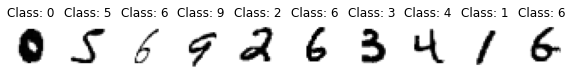

In [6]:
''' 4. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 5. MLP (Multi Layer Perceptron) 모델 설계하기 '''
class Net(nn.Module):                       
    def __init__(self):                     
        super(Net, self).__init__()         
        self.fc1 = nn.Linear(28 * 28, 512)  
        self.fc2 = nn.Linear(512, 256)      
        self.fc3 = nn.Linear(256, 10)      
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)
    
    def forward(self, x):                  
        x = x.view(-1, 28 * 28)            
        x = self.fc1(x)                    
        x = self.batch_norm1(x)
        x = F.relu(x)                      
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)                    
        x = self.batch_norm2(x)
        x = F.relu(x)                      
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)                    
        x = F.log_softmax(x, dim = 1)      
        return x                           

In [8]:
''' 6. Optimizer, Objective Function 설정하기 '''
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [9]:
''' 7. MLP 학습, Test 성능 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [10]:
def evaluate(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    valid_loss /= len(valid_loader.dataset)
    valid_accuracy = 100. * correct / len(valid_loader.dataset)
    return valid_loss, valid_accuracy

In [11]:
''' 8. MLP 학습 실행 '''
''' 9. EPOCH 별 Test set Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    valid_loss, valid_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tValidation Loss: {:.4f}, \tValidation Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.723103
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.515167
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.702115
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.616466
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.409077
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.375094
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.426608
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.556224
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.307271
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.343881

[EPOCH: 1], 	Validation Loss: 0.0048, 	Validation Accuracy: 95.42 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.403135
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.113229
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.339656
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.275661
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.464157
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.050349
Train Epoch: 2 [38400/60000 (64%)]	Train Loss